In [1]:
import sys
sys.path.append("/home/salmon/workspace/fytok/python")
sys.path.append("/home/salmon/workspace/SpDev/SpDB")

import collections
from spdm.util.logger import logger
from spdm.data.Collection import Collection
import matplotlib.pyplot as plt
import numpy as np
from scipy import special
import math

In [2]:
import fytok as tok
dir(tok)

['CoreProfiles',
 'CoreSources',
 'CoreTransports',
 'EdgeProfiles',
 'EdgeSources',
 'EdgeTransports',
 'Equilibrium',
 'FluxSurface',
 'Identifier',
 'PFActive',
 'Plot',
 'RadialProfile',
 'TF',
 'Tokamak',
 'TransportSolver',
 'Wall',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [2]:
db = Collection("east+mdsplus:///home/salmon/public_data/~t/",default_tree_name="efit_east")
entry = db.open(shot=55555).entry

2020-11-12 10:08:12,730 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/util/sp_export.py:77:sp_find_module: Can not find module spdm.data.plugins.Plugineast#eastCollection
2020-11-12 10:08:12,732 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/util/sp_export.py:77:sp_find_module: Can not find module spdm.data.plugins.PluginEast#EastCollection
2020-11-12 10:08:12,738 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/util/sp_export.py:75:sp_find_module: spdm.data.plugins.PluginEAST#EASTCollection
2020-11-12 10:08:12,739 INFO [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Plugin.py:84:find_plugin: Load Plugin: EASTCollection
2020-11-12 10:08:12,813 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/util/sp_export.py:75:sp_find_module: spdm.data.plugins.PluginMDSplus#MDSplusCollection
2020-11-12 10:08:12,815 INFO [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Plugin.py:84:find_plugin: Load Plugin: MDSplusCollection
2020-11-12 10:08:12,816 DEBUG [spdm] /home/salmon/works

In [3]:
vessel_inner_points= np.array([entry.wall.description_2d.vessel.annular.outline_inner.r.__value__(),    
                                          entry.wall.description_2d.vessel.annular.outline_inner.z.__value__()]).transpose([1,0]) 

vessel_outer_points= np.array([entry.wall.description_2d.vessel.annular.outline_outer.r.__value__(),    
                                          entry.wall.description_2d.vessel.annular.outline_outer.z.__value__()]).transpose([1,0])  

limiter_points =  np.array([entry.wall.description_2d[0].limiter.unit[0].outline.r.__value__(),
                                 entry.wall.description_2d[0].limiter.unit[0].outline.z.__value__()]).transpose([1,0]) 
isoflux=[
    (1.93, 0.15,    2.24, 0.52    ),   # isoflux03
    (1.99,0    ,    2.40, 0        ),     # isoflux01
    (1.93,-0.15,    2.24, -0.52    ),   # isoflux09
    (1.72, 0.24,    1.35, 0.45    ),   # isoflux04
    (1.66,0    ,    1.35, 0        ),     # isoflux06
    (1.72,-0.24 ,   1.35, -0.45    ),    # isoflux08

    ]                                 

In [4]:
sys.path.append("/home/salmon/workspace/freegs/")
import freegs
from freegs.machine import Machine,Wall
import freegs.equilibrium as equilibrium
import freegs.jtor as jtor
import freegs.picard as picard
import freegs.boundary as boundary
from  freegs.coil import Coil

In [5]:
itime=40000
coils = []
for coil in entry.pf_active.coil:
    rect = coil.element[0].geometry.rectangle.__value__()
    coils.append((str(coil.name), Coil(
    rect.r+rect.width/2, rect.z+rect.height/2,
    current= coil.current.data.__value__()[itime] ,
    turns=int(coil.element[0].turns_with_sign),
    # control=True
    )))

wall = Wall(entry.wall.description_2d[0].limiter.unit[0].outline.r.__value__(),
            entry.wall.description_2d[0].limiter.unit[0].outline.z.__value__())

Rdim=entry.equilibrium.time_slice[10].profiles_2d.grid.dim1.__value__()
Zdim=entry.equilibrium.time_slice[10].profiles_2d.grid.dim2.__value__()

lfcs_r=entry.equilibrium.time_slice[10].boundary.outline.r.__value__()[:,0]
lfcs_z=entry.equilibrium.time_slice[10].boundary.outline.z.__value__()[:,0]

EASTTokamak = Machine(coils, wall)



rmin=min(Rdim)
rmax=max(Rdim)
zmin=min(Zdim)
zmax=max(Zdim)

eq = equilibrium.Equilibrium(tokamak=EASTTokamak,
                                Rmin=rmin, Rmax=rmax,
                                Zmin=zmin, Zmax=zmax,
                                nx=129, ny=129,
                                boundary=boundary.freeBoundaryHagenow)




2020-11-12 10:08:19,790 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/plugins/PluginMDSplus.py:45:open_mdstree: Opend MDSTree: pcs_east 55555 mode="NORMAL"


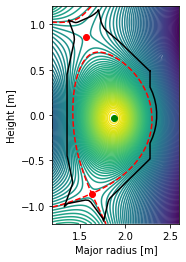

In [6]:
profiles = jtor.ConstrainPaxisIp(1e3,  # Plasma pressure on axis [Pascals]
                            1e6,  # Plasma current [Amps]
                            1.0)  # fvac = R*Bt

psivals = [ (R, Z, 0.0) for R, Z in zip(lfcs_r,lfcs_z)]
# psivals = [ (R, Z, 0.0) for R, Z in zip(entry.equilibrium.time_slice[10].boundary.outline.r.__value__(), 
#             entry.equilibrium.time_slice[10].boundary.outline.z.__value__()) ]


constrain = freegs.control.constrain(psivals=psivals)
freegs.solve(eq, profiles,constrain) 
ax=eq.plot(show=False)


<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

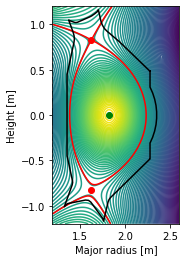

In [7]:
constrain=freegs.control.constrain(
    isoflux=[    
    ( 2.24, 0.52 ,  2.24,   -0.52     ),    
    ( 1.93, 0.15,   1.93,   -0.15,    ),    
    ( 1.99, 0 ,     1.66,   0),
  
   ],
    xpoints=[(1.63,-0.83),(1.63,0.83)]
)

freegs.solve(eq, profiles, constrain,maxits=200) 

eq.plot(show=False)




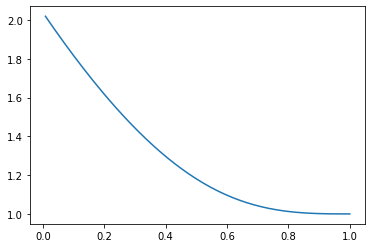

In [8]:
psinorm=np.linspace(1.0/128,1,128)
plt.plot(psinorm,eq.fpol(psinorm))

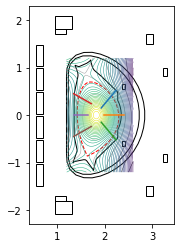

In [17]:
fg=plt.figure()

plt.gca().add_patch(plt.Polygon(limiter_points, fill=False,closed=True))
plt.gca().add_patch(plt.Polygon(vessel_outer_points , fill=False,closed=True))
plt.gca().add_patch(plt.Polygon(vessel_inner_points , fill=False,closed=True))

plt.gca().add_patch(plt.Polygon(np.array([lfcs_r,lfcs_z]).transpose([1,0]) , fill=False,closed=True,linestyle="dashed",color="red"))

for r0,z0,r1,z1 in isoflux:
    plt.plot([r0,r1],[z0,z1])

for coil  in entry.pf_active.coil:
    rect=coil.element[0].geometry.rectangle.__value__() 
    plt.gca().add_patch(plt.Rectangle((rect.r-rect.width/2.0, rect.z-rect.height/2.0),float( rect.width), float(rect.height), fill=False))
 

plt.contour(
    entry.equilibrium.time_slice[10].profiles_2d.grid.dim1.__value__(),
    entry.equilibrium.time_slice[10].profiles_2d.grid.dim2.__value__(),
    entry.equilibrium.time_slice[10].profiles_2d.psi.__value__(),
    linewidths=0.5,cmap="gray")

plt.contour(eq.R,eq.Z,eq.psi(),levels=50,linewidths=0.5)


plt.axis('scaled')
plt.show()


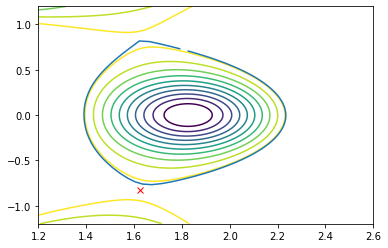

In [88]:
psi_norm=[*np.linspace(0.1,0.9,9),0.99]
psi=eq.psi()
C=plt.contour(eq.R,eq.Z,(psi-eq.psi_axis)/(eq.psi_bndry-eq.psi_axis),
levels=psi_norm)
sep=eq.separatrix(ntheta=128)
plt.plot(sep[:,0],sep[:,1])
plt.plot(eq.R[39,20],eq.Z[30,20],"rx")

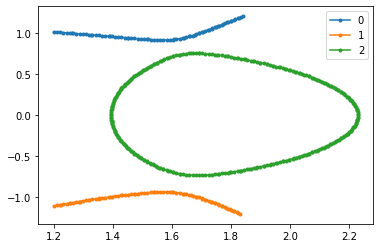

In [45]:
for ii, seg in enumerate(C.allsegs[-1]):
    plt.plot(seg[:,0], seg[:,1], '.-', label=ii)
    plt.legend()

In [73]:
from scipy import interpolate  


In [75]:
f=interpolate.RectBivariateSpline(eq.R[:,0], eq.Z[0,:], eq.psi())

In [206]:
Br=-f(eq.R,eq.Z,dy=1,grid=False)/eq.R
Bz= f(eq.R,eq.Z,dx=1,grid=False)/eq.R
Bp2=Br**2+Bz**2
Bp=np.sqrt(Bp2)

In [93]:
dbp2=interpolate.RectBivariateSpline(eq.R[:,0], eq.Z[0,:], Bp2)


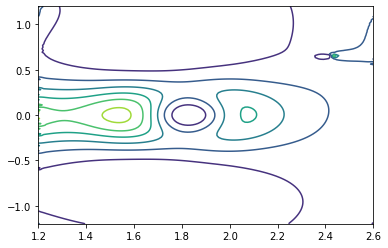

In [115]:
plt.contour(eq.R,eq.Z, Bp2)

In [112]:
np.linspace(-1,1,5)

array([-1. , -0.5,  0. ,  0.5,  1. ])

In [172]:
from scipy.ndimage.filters import maximum_filter,minimum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion




def detect_peaks(image):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    neighborhood = generate_binary_structure(2,2)

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = minimum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.

    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background

    return detected_peaks

span=5

ridx,zidx =np.where( detect_peaks( Bp2[span:-span,span:-span]))
    



(1.2, 2.6, -1.2, 1.2)

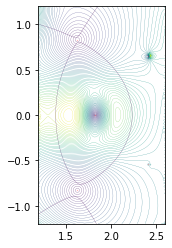

In [210]:
r= [  eq.R[ridx[i]+span,zidx[i]+span]   for i  in range(len(ridx)) ]
z= [  eq.Z[ridx[i]+span,zidx[i]+span]   for i  in range(len(ridx)) ]

plt.plot(r,z,"r.", linewidth=0.2 ,markersize=0.2)
plt.contour(eq.R,eq.Z, psi, levels=[1.01*eq.psi_bndry,eq.psi_axis], linewidths=0.2)
plt.contour(eq.R,eq.Z,Bp ,levels=np.linspace(0,Bp.max(),50), linewidths=0.2)
# plt.contour(eq.R,eq.Z, f(eq.R,eq.Z,dx=2,dy=1,grid=False)/eq.R,levels=np.linspace(-10,10,20))
plt.gca().axis("scaled")

In [211]:
from sympy import Point ,Polygon

In [214]:
limiter_polygon=Polygon(*map(Point,limiter_points))

In [221]:
limiter_polygon.encloses_point (Point(r[0],z[0]))

True

In [239]:
x_idx, y_idx = np.where( detect_peaks( Bp2[span:-span,span:-span]))
p_idx=np.array([x_idx, y_idx]).transpose(1, 0)
p_xy=np.array([ [eq.R[idx[0],idx[1]],eq.Z[idx[0],idx[1]]] for idx in p_idx])

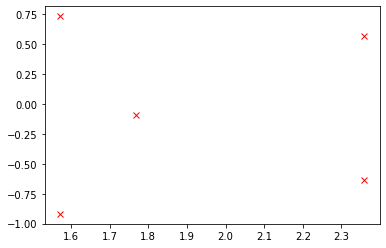

In [240]:
plt.plot(p_xy[:,0],p_xy[:,1],"rx")

In [238]:
p_xy.shape

AttributeError: 'list' object has no attribute 'shape'

In [241]:
for idx,p in enumerate(p_xy):
    print((idx,p))

(0, array([ 1.571875, -0.91875 ]))
(1, array([1.571875, 0.73125 ]))
(2, array([ 1.76875, -0.09375]))
(3, array([ 2.359375, -0.6375  ]))
(4, array([2.359375, 0.5625  ]))
